In [1]:
import numpy as np
import scipy.linalg

from IPython.display import display, HTML, Latex
from numpy import array, dot, cos, sin, pi

### Метод вращений Якоби 

#### Когда работает: 

Матрица $A$ является симметрической (отсюда следует существование полного спектра).

#### Идея алгоритма: 

Поскольку матрица имеет полный спектр, его можно представить как исходный базис пространства столбцов матрицы, который повёрнут на определённый угол. Значит, мы можем поочерёдно поворачивать отдельные пары базисных векторов, пока не повернём все как надо. Каждый поворот пары базисных векторов будет выражаться в обнулении двух соответствующих внедиагональных элементов матрицы $A$.

#### Формальное описание алгоритма:

Поворот пары базисных векторов $i_k, j_k$ формально выражается таким итерационным шагом: $A^{(k+1)}=U^{(k)T}A^{(k)}U^{(k)}$, где матрица $U^{(k)}$ является матрицей поворота вдоль базисных векторов с номерами $i_k, j_k$ на угол $\varphi$ (её подматрица в $i$х и $j$х строках и столбцах является обычной матрицей поворота в двухмерном пространстве) а угол $\varphi_k$ находится из условия $a_{i_k j_k} \approx 0$ по формуле...

Повторять такой шаг мы будем до момента выполнения критерия сходимости - приблизительного обнуления всех внедиагональных элементов, что, ввиду симметричности матрицы на каждом шагу, выразится в таком условии: 
$$t(A^{(k)}) = \sqrt{\sum_{i=1}^{n}\sum_{j=i+1}^{n} (A^{(k)}_{ij})^2} < \varepsilon.$$

_(На самом деле более корректно было бы называть матрицу, в которой мы зануляем элементы, не $A^{(k)}$, а $\Lambda^{(k)}$, поскольку именно её мы и примем за диагональную матрицу с собственными значениями)._

В момент, когда алгоритм сойдётся, мы полагаем 
$\Lambda = A^{(k)}$, в частности, $\lambda_i = A_{ii} \forall i = \overline{1, n}$, а в качестве матрицы собственных векторов возьмём матрицу $U = U^{(0)}U^{(1)}...U^{(k-1)}$.


#### Свойства алгоритма:


In [2]:
def Jacobi_method(A, eps, show_history=False):
    
    n = A.shape[0]
    
    def get_Uk(Ak):
        nonlocal n
        Uk = np.identity(n)
        ind = np.argmax(np.abs(np.triu(Ak, k=1)))
        ik, jk = ind // n, ind % n
        phi_k = pi / 4 if Ak[ik, ik] == Ak[jk, jk] else 0.5 * np.arctan(2*Ak[ik, jk] / (Ak[ik, ik] - Ak[jk, jk]))
        Uk[[ik, ik, jk, jk], [ik, jk, ik, jk]] = array([cos(phi_k), -sin(phi_k), sin(phi_k), cos(phi_k)])
        return Uk
    
    def t(Ak):
        return np.linalg.norm(np.triu(np.abs(Ak), k=1))
    
    Ak = A.copy()
    U = np.identity(n)
    if show_history:
        k = 0
        display(HTML('t(A<sub>0</sub>) = {}'.format(t(Ak))))
        
    while t(Ak) >= eps:
        Uk = get_Uk(Ak)
        U = dot(U, Uk)
        Ak = dot(dot(Uk.T, Ak), Uk)
        if show_history:
            k = k + 1
            display(HTML('A<sub>{ind}</sub>:'.format(ind=k)))
            print(Ak)
            display(HTML('U<sub>{ind}</sub>:'.format(ind=k-1)))
            print(Uk)
            display(HTML('t(A<sub>{ind}</sub>) = {t}'.format(ind=k, t=t(Ak))))
            print('_'*50)
            
    return np.diag(Ak), U   

### Степенной метод 

In [3]:
def power_method(A, eps, full_eigenproblem=False, show_history=False, random_state=0):
    
    n = A.shape[0]
    np.random.seed(random_state)
    k = 0
    
    x_curr = np.random.rand(n) # x_0
    x_next = dot(A, x_curr)
    lambda_prev = dot(x_next, x_curr) / dot(x_curr, x_curr)
    if show_history:
        e1_curr = x_curr / np.linalg.norm(x_curr)
        display(Latex('$x^{(0)} = (' + ', '.join(map(str, x_curr.round(4))) + ')^{T}$')) # x_0
        display(Latex('$x^{(1)} = (' + ', '.join(map(str, x_next.round(4))) + ')^{T}$'))  # x_1
        display(Latex('$\lambda_1^{(0)} = ' + str(round(lambda_prev, 4)) + '$')) # lambda_0
        display(Latex('$\mathbf{e}_1^{(0)} = (' + ', '.join(map(str, e1_curr.round(4))) + ')^{T}$')) # e_0
        
    while True:
        k = k + 1
        x_curr = x_next / np.linalg.norm(x_next)
        x_next = dot(A, x_curr)
        lambda_curr = dot(x_next, x_curr) / dot(x_curr, x_curr)
        if show_history:
            print('-'*50)
            e1_curr = x_curr / np.linalg.norm(x_curr)
            display(Latex('$x^{(%d)} = (' % (k+1) + ', '.join(map(str, x_next.round(4))) + ')^{T}$')) # x_{k+1}
            display(Latex('$\lambda_1^{(%d)} = ' % k + str(round(lambda_curr, 4)) + '$')) # lambda_k
            display(Latex('$\mathbf{e}_1^{(%d)} = (' % k + ', '.join(map(str, e1_curr.round(4))) + ')^{T}$')) # e_k
            
        if np.abs(lambda_curr - lambda_prev) < eps:
            break    
        lambda_prev = lambda_curr
    
    return lambda_curr, x_next / np.linalg.norm(x_next)

### QR-алгоритм

#### Когда работает: 
Для произвольной матрицы $A$. Позволяет найти собственные значения (даже, если они комплексны, однако в таком случае появляются свои детали).

#### Идея алгоритма: 
Алгоритм основан на том факте, что подобные матрицы имеют одинаковые наборы собственных значений. Так почему бы не найти матрицу $A'$, подобную матрице $A$ (т.е., $A'=Q^{*}AQ$), но имеющую удобный вид, например, верхний диагональный? Тогда собственные значения просто будут совпадать с диагональными элементами. 

Найти её просто так, конечно, не получается, однако легко построить последовательность матриц $A^{(k)}$, сходящихся по форме к верхней треугольной. Делается это, при том, достаточно просто, с применением $QR$-разложения: всякая очередная матрица $A^{(k)}$ представляется в виде $$A^{(k)}=Q^{(k)}R^{(k)},$$ где $Q^{(k)}$ - ортогональная матрица, а $R^{(k)}$ - верхняя треугольная. Следующая же матрица просто получается путем перемножения двух последних в другом порядке: 
$$A^{(k+1)}=R^{(k)}Q^{(k)}=Q^{(k)*}Q^{(k)}R^{(k)}Q^{(k)}= Q^{(k)*}A^{(k)}Q^{(k)}.$$
Как видим, если развернуть эту цепочку, получим, что все матрицы последовательности подобны исходной, и можно показать, что они сходятся к верхней треугольной. 

Критерий остановки можем выбрать такой же, как и в первом методе (только вместо верхней части матрицы рассматривать лишь элеметы _под_ главной диагональю).

$QR$-разложение можно производить с помощью процедуры Грамма-Шмидта, или, например, с помощью преобразований отражения Хаусхолдера и преобразования вращения Гивенса. Мы же воспользуемся встроенной реализацией.



### Проблема: как работать с квази-треугольной матрицей-то? 

In [17]:
def r_hessenberg(A):
    
    B = A
    n = A.shape[0]
    for i in range(n-2):
        s = np.sign(-B[i+1, i]) * np.linalg.norm(B[i+1:, i])
        mu = 1 / np.sqrt(2 * s * (s - B[i+1, i]))
        w = np.zeros(n)
        w[:i+1] = 0; w[i+1] = B[i+1, i] - s; w[i+2:]=B[i+2:, i]
        w = mu * w
        H = np.identity(n) - 2 * np.outer(w, w)
        B = dot(H, dot(B, H))
    
    return B

In [4]:
# в данный момент сработает только для матриц с полным действительным спектром.

def QR(A, eps, show_history=False):
    
    def t(Ak):
        return np.linalg.norm(np.tril(Ak, k=-1)) 
    
    Ak = A.copy()
    k = 0
    while t(Ak) >= eps:
        input()
        Qk, Rk = np.linalg.qr(Ak)
        Ak = dot(Rk, Qk)
        if show_history: 
            k = k + 1
            display(HTML('Q<sub>{ind}</sub>:'.format(ind=k)), )
            print(Qk)
            display(HTML('R<sub>{ind}</sub>:'.format(ind=k)), )
            print(Rk)
            display(HTML('A<sub>{ind}</sub>:'.format(ind=k+1)), )
            print(Ak)
            print('_'*50)
    
    return np.diag(Ak)    

In [5]:
def plot_gershgorin_circles(A, ranges=(-5, 25, -10, 10), with_real_eigv=False):
    %matplotlib notebook
    import matplotlib.pyplot as plt
    from matplotlib.patches import Circle
    
    fig, ax = plt.subplots(figsize=(6, 5))
    fig.patch.set_facecolor('white')
    fig.patch.set_alpha(1)
    ax.set_aspect('equal')
    
    # Move left y-axis and bottim x-axis to centre, passing through (0,0)
    ax.spines['left'].set_position('zero')
    ax.spines['bottom'].set_position('zero')

    # Eliminate upper and right axes
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')

    # Show ticks in the left and lower axes only
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    #ax.xaxis.arrow()
    
    n = A.shape[0]
    sums = np.abs(A).sum(axis=1)
    for i in range(n):
        ax.add_patch(Circle((A[i, i], 0), radius=sums[i]-abs(A[i, i]), edgecolor='black', facecolor="None"))
        
    ax.axis(ranges)
    
    if with_real_eigv:
        l = np.linalg.eigvals(A)
        ax.scatter(l.real, l.imag, c='red')

    plt.show()
    return fig, ax

## Пример применения 

## Часть 1: Степенной метод и метод Якоби, матрица 4х4

In [7]:
A1 = array([
    [ 3.77, 0.56, -1.45, 1.66],
    [ 0.56, 9.56,  5.23, 1.62],
    [-1.45, 5.23, 12.87, 1.99],
    [ 1.66, 1.62,  1.99, 6.89] 
])

In [8]:
l_true, U_true = np.linalg.eig(A1)
print(l_true)

[ 17.34291473   2.42809989   7.54370244   5.77528294]


In [9]:
print(U_true)

[[ 0.03163384  0.8586932  -0.505117   -0.08063564]
 [-0.57353621 -0.1925787  -0.24221756 -0.75848554]
 [-0.78463647  0.28771043  0.37608455  0.40016088]
 [-0.2332405  -0.37786524 -0.73807038  0.50800477]]


<IPython.core.display.Javascript object>


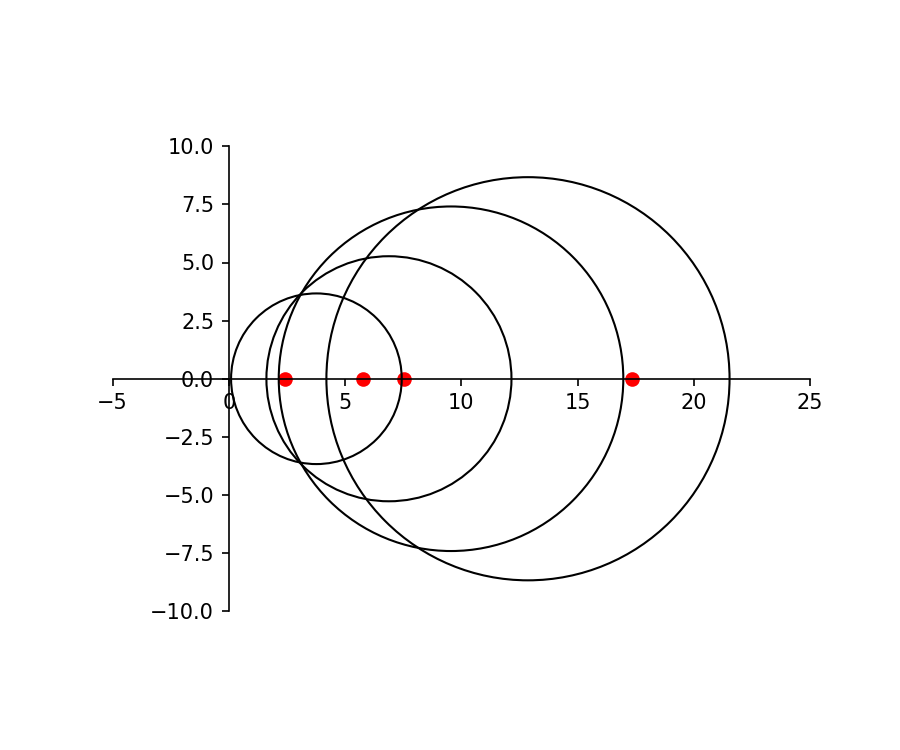

In [10]:
fig, ax = plot_gershgorin_circles(A1, with_real_eigv=True);

In [11]:
l, U = Jacobi_method(A1, 1e-4, True)

[[  3.77000000e+00   1.30857153e+00  -8.38892463e-01   1.66000000e+00]
 [  1.30857153e+00   5.72938928e+00   0.00000000e+00   1.31067881e-01]
 [ -8.38892463e-01  -8.88178420e-16   1.67006107e+01   2.56267852e+00]
 [  1.66000000e+00   1.31067881e-01   2.56267852e+00   6.89000000e+00]]


[[ 1.          0.          0.          0.        ]
 [ 0.          0.80675226  0.59088984  0.        ]
 [ 0.         -0.59088984  0.80675226  0.        ]
 [ 0.          0.          0.          1.        ]]


__________________________________________________


[[  3.77000000e+00   1.30857153e+00  -4.18966048e-01   1.81212803e+00]
 [  1.30857153e+00   5.72938928e+00   3.12462085e-02   1.27288899e-01]
 [ -4.18966048e-01   3.12462085e-02   1.73296835e+01   8.88178420e-16]
 [  1.81212803e+00   1.27288899e-01   0.00000000e+00   6.26092718e+00]]


[[ 1.          0.          0.          0.        ]
 [ 0.          1.          0.          0.        ]
 [ 0.          0.          0.97116775 -0.23839714]
 [ 0.          0.          0.23839714  0.97116775]]


__________________________________________________


[[  2.81660307e+00   1.09880511e+00  -3.70780596e-01   0.00000000e+00]
 [  1.09880511e+00   5.72938928e+00   3.12462085e-02   7.21934373e-01]
 [ -3.70780596e-01   3.12462085e-02   1.73296835e+01  -1.95075113e-01]
 [  4.44089210e-16   7.21934373e-01  -1.95075113e-01   7.21432410e+00]]


[[ 0.8849896   0.          0.          0.46561079]
 [ 0.          1.          0.          0.        ]
 [ 0.          0.          1.          0.        ]
 [-0.46561079  0.          0.          0.8849896 ]]


__________________________________________________


[[  2.44859120e+00   0.00000000e+00  -3.61508858e-01  -2.29273054e-01]
 [ -2.22044605e-16   6.09740115e+00  -8.81244627e-02   6.84560520e-01]
 [ -3.61508858e-01  -8.81244627e-02   1.73296835e+01  -1.95075113e-01]
 [ -2.29273054e-01   6.84560520e-01  -1.95075113e-01   7.21432410e+00]]


[[ 0.94823096  0.31758157  0.          0.        ]
 [-0.31758157  0.94823096  0.          0.        ]
 [ 0.          0.          1.          0.        ]
 [ 0.          0.          0.          1.        ]]


__________________________________________________


[[  2.44859120e+00   9.83298661e-02  -3.61508858e-01  -2.07116804e-01]
 [  9.83298661e-02   5.77240220e+00   4.05478354e-03   1.79049621e-16]
 [ -3.61508858e-01   4.05478354e-03   1.73296835e+01  -2.14018175e-01]
 [ -2.07116804e-01   5.00582027e-16  -2.14018175e-01   7.53932305e+00]]


[[ 1.          0.          0.          0.        ]
 [ 0.          0.90336305  0.          0.42887668]
 [ 0.          0.          1.          0.        ]
 [ 0.         -0.42887668  0.          0.90336305]]


__________________________________________________


[[  2.43981418e+00   9.83993145e-02   4.93072158e-17  -2.12250371e-01]
 [  9.83993145e-02   5.77240220e+00   1.66695655e-03   1.79049621e-16]
 [ -3.07286480e-17   1.66695655e-03   1.73384606e+01  -2.08928049e-01]
 [ -2.12250371e-01   5.00582027e-16  -2.08928049e-01   7.53932305e+00]]


[[ 0.9997054   0.         -0.02427169  0.        ]
 [ 0.          1.          0.          0.        ]
 [ 0.02427169  0.          0.9997054   0.        ]
 [ 0.          0.          0.          1.        ]]


__________________________________________________


[[  2.43099520e+00   9.83144864e-02  -8.67345016e-03   1.38777878e-17]
 [  9.83144864e-02   5.77240220e+00   1.66695655e-03  -4.08495438e-03]
 [ -8.67345016e-03   1.66695655e-03   1.73384606e+01  -2.08747936e-01]
 [  2.77555756e-16  -4.08495438e-03  -2.08747936e-01   7.54814203e+00]]


[[ 0.99913792  0.          0.         -0.04151405]
 [ 0.          1.          0.          0.        ]
 [ 0.          0.          1.          0.        ]
 [ 0.04151405  0.          0.          0.99913792]]


__________________________________________________


[[  2.43099520e+00   9.83144864e-02  -8.67148105e-03  -1.84808245e-04]
 [  9.83144864e-02   5.77240220e+00   1.75361766e-03  -4.04850856e-03]
 [ -8.67148105e-03   1.75361766e-03   1.73429094e+01  -5.55111512e-17]
 [ -1.84808245e-04  -4.04850856e-03  -3.33066907e-16   7.54369315e+00]]


[[ 1.          0.          0.          0.        ]
 [ 0.          1.          0.          0.        ]
 [ 0.          0.          0.99977297  0.02130735]
 [ 0.          0.         -0.02130735  0.99977297]]


__________________________________________________


[[  2.42810499e+00   0.00000000e+00  -8.71926641e-03  -6.57631876e-05]
 [ -3.05311332e-16   5.77529242e+00   1.49804929e-03  -4.05219087e-03]
 [ -8.71926641e-03   1.49804929e-03   1.73429094e+01  -5.55111512e-17]
 [ -6.57631876e-05  -4.05219087e-03  -3.33066907e-16   7.54369315e+00]]


[[ 0.99956817  0.02938496  0.          0.        ]
 [-0.02938496  0.99956817  0.          0.        ]
 [ 0.          0.          1.          0.        ]
 [ 0.          0.          0.          1.        ]]


__________________________________________________


[[  2.42809989e+00   8.75766373e-07  -1.65410407e-18  -6.57631764e-05]
 [  8.75766372e-07   5.77529242e+00   1.49804904e-03  -4.05219087e-03]
 [ -3.58771027e-17   1.49804904e-03   1.73429145e+01   3.84454560e-08]
 [ -6.57631764e-05  -4.05219087e-03   3.84454557e-08   7.54369315e+00]]


[[  9.99999829e-01   0.00000000e+00  -5.84604509e-04   0.00000000e+00]
 [  0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  5.84604509e-04   0.00000000e+00   9.99999829e-01   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   1.00000000e+00]]


__________________________________________________


[[  2.42809989e+00   7.25072639e-07  -1.65410407e-18  -6.57650105e-05]
 [  7.25072639e-07   5.77528313e+00   1.49804519e-03  -1.69820860e-18]
 [ -3.58771027e-17   1.49804519e-03   1.73429145e+01  -3.39422276e-06]
 [ -6.57650105e-05   2.92092299e-16  -3.39422276e-06   7.54370244e+00]]


[[ 1.          0.          0.          0.        ]
 [ 0.          0.99999737  0.         -0.00229143]
 [ 0.          0.          1.          0.        ]
 [ 0.          0.00229143  0.          0.99999737]]


__________________________________________________


[[  2.42809989e+00   7.25072633e-07   9.38992173e-11  -6.57650105e-05]
 [  7.25072632e-07   5.77528294e+00  -3.25260652e-19   4.39562669e-10]
 [  9.38991830e-11  -1.19522447e-15   1.73429147e+01  -3.39422273e-06]
 [ -6.57650105e-05   4.39562963e-10  -3.39422273e-06   7.54370244e+00]]


[[  1.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   9.99999992e-01   1.29503189e-04   0.00000000e+00]
 [  0.00000000e+00  -1.29503189e-04   9.99999992e-01   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   1.00000000e+00]]


__________________________________________________


In [12]:
U

array([[ 0.85868672,  0.08063545, -0.03163366,  0.50512805],
       [-0.19258165,  0.75848558,  0.57353629,  0.24221488],
       [ 0.28771518, -0.40016094,  0.78463634, -0.37608112],
       [-0.37787484, -0.50800469,  0.23324076,  0.73806544]])

In [13]:
lambda_1, e_1 = power_method(A1, 1e-4, False, True)

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

--------------------------------------------------


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

--------------------------------------------------


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

--------------------------------------------------


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

--------------------------------------------------


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

--------------------------------------------------


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

--------------------------------------------------


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

--------------------------------------------------


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

--------------------------------------------------


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [14]:
e_1

array([-0.03145606,  0.57362393,  0.78450288,  0.23349806])

In [15]:
U[:, 2]

array([-0.03163366,  0.57353629,  0.78463634,  0.23324076])

## Часть 2: применение QR-алгоритма, матрица 3х3

In [22]:
A2 = array([
    [ 9,  0, 2],
    [-6,  4, 4],
    [-2, -7, 5]
])

l = np.linalg.eigvals(A2)
print(l)

[ 10.02727470+0.j           3.98636265+6.09624525j   3.98636265-6.09624525j]


<IPython.core.display.Javascript object>


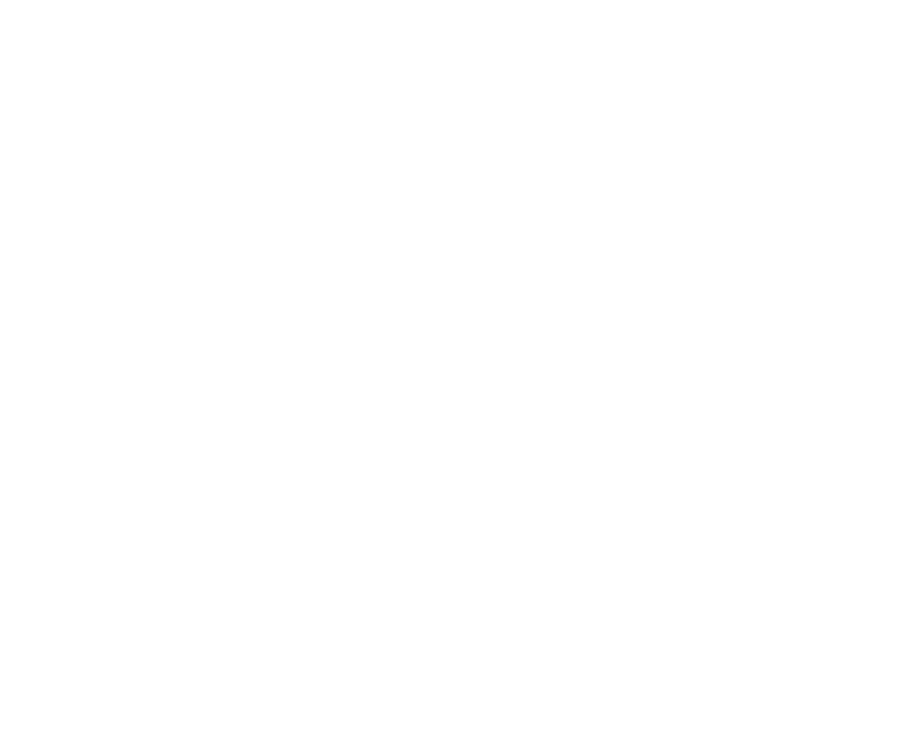

In [8]:
plot_gershgorin_circles(A2, ranges=(-10, 15, -12, 12), with_real_eigv=True);

<IPython.core.display.Javascript object>


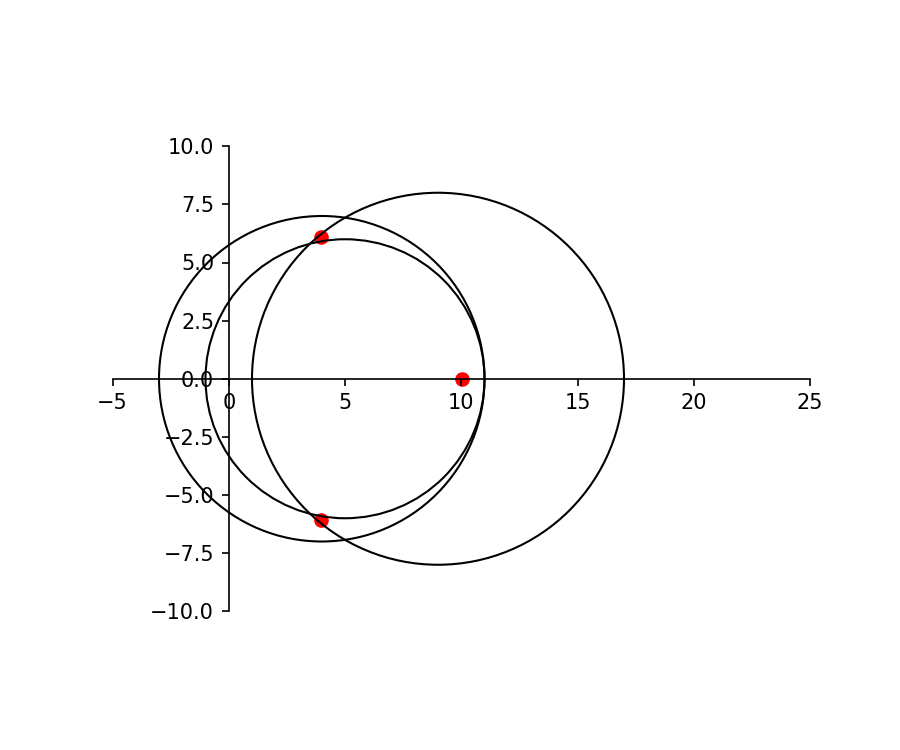

In [9]:
plot_gershgorin_circles(A2.T, with_real_eigv=True);

In [18]:
B = r_hessenberg(A2)

[[ 9.  0.  2.]
 [-6.  4.  4.]
 [-2. -7.  5.]]
6.32456
0.0800911207686
[ 0.         -0.98708745 -0.16018224]
[[ 0.         -0.         -0.        ]
 [-0.          0.97434164  0.15811388]
 [-0.          0.15811388  0.02565835]]
[[ 1.          0.          0.        ]
 [ 0.         -0.94868329 -0.31622776]
 [ 0.         -0.31622776  0.9486833 ]]
[[  9.00000000e+00  -6.32455524e-01   1.89736660e+00]
 [  6.32455524e+00   3.19999992e+00  -4.59999996e+00]
 [ -2.48923977e-08   6.39999991e+00   5.79999999e+00]]


In [39]:
QR(B, 1e-4, True)

[[ -8.18181821e-01   2.42817777e-01   5.21169871e-01]
 [ -5.74959570e-01  -3.45535762e-01  -7.41637735e-01]
 [  2.26294525e-09  -9.06446118e-01   4.22321484e-01]]


[[-10.99999996  -1.32240695   1.09242315]
 [  0.          -7.06054093  -3.20720864]
 [  0.           0.           6.84984846]]


[[  9.76033053e+00  -3.20427937e+00  -4.29076789e+00]
 [  4.05952557e+00   5.34683121e+00   3.88189047e+00]
 [  1.55008321e-08  -6.20901854e+00   2.89283816e+00]]
__________________________________________________



[[ -9.23321200e-01   2.70634049e-01  -2.72461324e-01]
 [ -3.84028595e-01  -6.50686328e-01   6.55079645e-01]
 [ -1.46636907e-09   7.09481863e-01   7.04723695e-01]]


[[-10.570894     0.905243     2.47100002]
 [  0.          -8.75148311  -1.63470473]
 [  0.           0.           5.75066733]]


[[  9.41269133e+00  -1.69674340e+00   5.21453830e+00]
 [  3.36081976e+00   4.53467705e+00  -6.88493360e+00]
 [ -8.43260073e-09   4.07999417e+00   4.05263153e+00]]
__________________________________________________



[[ -9.41769027e-01   2.57125040e-01   2.16697516e-01]
 [ -3.36260464e-01  -7.20133425e-01  -6.06907530e-01]
 [  8.43707915e-10  -6.44433522e-01   7.64660340e-01]]


[[-9.99469197  0.07310777 -2.59575969]
 [ 0.         -6.33113274  3.68720758]
 [ 0.          0.          8.40738215]]


[[  9.38810808e+00  -9.49738375e-01  -4.19506906e+00]
 [  2.12890964e+00   2.18310014e+00   6.66187354e+00]
 [  7.09337487e-09  -5.41799889e+00   6.42879170e+00]]
__________________________________________________



[[ -9.75239407e-01   8.76564480e-02  -2.03038040e-01]
 [ -2.21151754e-01  -3.86549152e-01   8.95361187e-01]
 [ -7.36861852e-10   9.18093732e-01   3.96363343e-01]]


[[-9.62646506  0.44342587  2.61791164]
 [ 0.         -5.90135701  2.95936694]
 [ 0.          0.          9.36467897]]


[[  9.29004367e+00   1.38826064e+00   3.38920912e+00]
 [  1.30509546e+00   4.99814079e+00  -4.11086145e+00]
 [ -6.90047468e-09   8.59765306e+00   3.71181546e+00]]
__________________________________________________



[[ -9.90275927e-01   6.73440598e-02   1.21730709e-01]
 [ -1.39117173e-01  -4.79374332e-01  -8.66514086e-01]
 [  7.35558864e-10  -8.75022873e-01   4.84081576e-01]]


[[-9.3812678  -2.0700883  -2.78436077]
 [ 0.         -9.82563237 -1.04903886]
 [ 0.          0.          5.77151166]]


[[  9.57802850e+00   2.79695390e+00  -6.96085454e-01]
 [  1.36691420e+00   5.62808895e+00   8.00622847e+00]
 [  4.24528656e-09  -5.05020471e+00   2.79388246e+00]]
__________________________________________________



[[ -9.89969389e-01   1.01127278e-01  -9.86604421e-02]
 [ -1.41282020e-01  -7.08603330e-01   6.91318097e-01]
 [ -4.38785888e-10   6.98322701e-01   7.15783072e-01]]


[[-9.67507542 -3.56404652 -0.44203284]
 [ 0.         -7.23190683 -3.79260184]
 [ 0.          0.          7.6033405 ]]


[[  1.00815642e+01   1.23839962e+00  -1.82574226e+00]
 [  1.02173841e+00   2.47609331e+00  -7.71422826e+00]
 [ -3.33623851e-09   5.30958527e+00   5.44234242e+00]]
__________________________________________________



[[ -9.94903598e-01   4.06431838e-02   9.22765547e-02]
 [ -1.00830704e-01  -4.01029134e-01  -9.10499205e-01]
 [  3.29238166e-10  -9.15163245e-01   4.03083409e-01]]


[[-10.13320709  -1.48175447   2.59426862]
 [  0.          -5.80179034  -1.96120544]
 [  0.           0.           9.04904343]]


[[  1.02309705e+01  -2.19179837e+00   1.45978547e+00]
 [  5.84998606e-01   4.12151010e+00   4.49199612e+00]
 [  2.97929046e-09  -8.28135195e+00   3.64751928e+00]]
__________________________________________________



[[ -9.98369268e-01   2.60155586e-02  -5.08133439e-02]
 [ -5.70859458e-02  -4.54982993e-01   8.88668482e-01]
 [ -2.90728238e-10   8.90120030e-01   4.55726160e-01]]


[[-10.24768176   1.95294384  -1.7138348 ]
 [  0.          -9.3036351    1.24092527]
 [  0.           0.           5.57998874]]


[[  1.01194849e+01  -2.68067408e+00   1.47519926e+00]
 [  5.31106809e-01   5.33756818e+00  -7.70232518e+00]
 [ -1.62226030e-09   4.96685975e+00   2.54294684e+00]]
__________________________________________________



[[ -9.98625576e-01   3.88043799e-02   3.52303824e-02]
 [ -5.24114467e-02  -7.39362272e-01  -6.71264829e-01]
 [  1.60090226e-10  -6.72188702e-01   7.40379868e-01]]


[[-10.1334125    2.39724003  -1.0694817 ]
 [  0.          -7.38908543   4.0427127 ]
 [  0.           0.           7.10501848]]


[[  9.99384207e+00  -1.44675610e+00  -2.75800964e+00]
 [  3.87272658e-01   2.74574520e+00   7.95317627e+00]
 [  1.13744401e-09  -4.77591315e+00   5.26041264e+00]]
__________________________________________________



[[ -9.99250020e-01   1.95826812e-02  -3.34053436e-02]
 [ -3.87220658e-02  -5.05344801e-01   8.62048278e-01]
 [ -1.13729129e-10   8.62695283e-01   5.05724084e-01]]


[[-10.00134288   1.33935014   2.44797777]
 [  0.          -5.53603716   0.46502767]
 [  0.           0.           9.60847153]]


[[  9.94197967e+00   1.23917214e+00   2.72668409e+00]
 [  2.14366796e-01   3.19878478e+00  -4.53715561e+00]
 [ -1.09276310e-09   8.28918306e+00   4.85923547e+00]]
__________________________________________________



[[ -9.99767626e-01   7.70283171e-03   2.01335733e-02]
 [ -2.15567713e-02  -3.57244680e-01  -9.33762038e-01]
 [  1.09888493e-10  -9.33979071e-01   3.57327714e-01]]


[[-9.94429046 -1.30783965 -2.62824405]
 [ 0.         -8.87512721 -2.89654633]
 [ 0.          0.          6.02786107]]


[[  9.97017247e+00   2.84534450e+00   8.18524827e-02]
 [  1.91319087e-01   5.87590563e+00   7.25224059e+00]
 [  6.62392570e-10  -5.62989608e+00   2.15392181e+00]]
__________________________________________________



[[ -9.99815939e-01   1.37898876e-02  -1.33389188e-02]
 [ -1.91856133e-02  -7.18629594e-01   6.95128347e-01]
 [ -6.64251949e-11   6.95256316e-01   7.18761890e-01]]


[[-9.97200792 -2.95755364 -0.2209761 ]
 [ 0.         -8.09758351 -3.71301823]
 [ 0.          0.          6.5883031 ]]


[[  1.00269149e+01   1.83423767e+00  -2.08169276e+00]
 [  1.55357106e-01   3.23766377e+00  -8.29763584e+00]
 [ -4.37629318e-10   4.58055934e+00   4.73542119e+00]]
__________________________________________________



[[ -9.99879989e-01   8.88875066e-03   1.26884512e-02]
 [ -1.54921491e-02  -5.73689544e-01  -8.18926309e-01]
 [  4.36402223e-11  -8.19024601e-01   5.73758402e-01]]


[[-10.02811843  -1.88417591   2.20999115]
 [  0.          -5.59270056   0.86333683]
 [  0.           0.           9.48572653]]


[[  1.00561049e+01  -8.18242543e-01   2.68376093e+00]
 [  8.66429509e-02   2.50137974e+00   5.07535639e+00]
 [  4.13959215e-10  -7.76904338e+00   5.44251529e+00]]
__________________________________________________



[[ -9.99962885e-01   2.64712069e-03  -8.19889801e-03]
 [ -8.61563559e-03  -3.07234730e-01   9.51594762e-01]
 [ -4.11634381e-11   9.51630082e-01   3.07246134e-01]]


[[-10.05647813   0.7966612   -2.72738874]
 [  0.          -8.16393211   3.62703976]
 [  0.           0.           6.47987045]]


[[  1.00492411e+01  -2.86684787e+00   2.57101561e-03]
 [  7.03374639e-02   5.95984363e+00  -6.65436109e+00]
 [ -2.66733746e-10   6.16643965e+00   1.99091514e+00]]
__________________________________________________



[[ -9.99975506e-01   4.87247881e-03   5.02458821e-03]
 [ -6.99910969e-03  -6.96139895e-01  -7.17872035e-01]
 [  2.65420253e-11  -7.17889619e-01   6.96156947e-01]]


[[-10.04948729   2.82506405   0.04400365]
 [  0.          -8.58967659   3.20312145]
 [  0.           0.           6.16298206]]


[[  1.00294682e+01  -2.04719547e+00  -2.04789557e+00]
 [  6.01200887e-02   3.68012893e+00   8.39616386e+00]
 [  1.63578026e-10  -4.42434085e+00   4.29040278e+00]]
__________________________________________________



[[ -9.99982034e-01   3.84072078e-03  -4.60214516e-03]
 [ -5.99423692e-03  -6.40724056e-01   7.67747845e-01]
 [ -1.63094477e-11   7.67761638e-01   6.40735567e-01]]


[[-10.0296484    2.02509913   1.99753018]
 [  0.          -5.76264901  -2.09348289]
 [  0.           0.           9.20457508]]


[[  1.00173293e+01   1.97576237e-01   2.88081202e+00]
 [  3.45426835e-02   2.08497200e+00  -5.76563031e+00]
 [ -1.50121536e-10   7.06691964e+00   5.89769863e+00]]
__________________________________________________



[[ -9.99994055e-01   9.75472532e-04   3.30742113e-03]
 [ -3.44827220e-03  -2.82885657e-01  -9.59147442e-01]
 [  1.49860945e-11  -9.59153144e-01   2.82887339e-01]]


[[-10.01738884  -0.20476461  -2.86091343]
 [  0.          -7.36787413  -4.02297192]
 [  0.           0.           7.20800189]]


[[  1.00180354e+01   2.79220740e+00  -6.46048454e-01]
 [  2.54064355e-02   5.94291207e+00   5.92882980e+00]
 [  1.08019797e-10  -6.91357767e+00   2.03905247e+00]]
__________________________________________________



[[ -9.99996784e-01   1.65203283e-03  -1.92416098e-03]
 [ -2.53606150e-03  -6.51414613e-01   7.58717714e-01]
 [ -1.07824984e-11   7.58720154e-01   6.51416708e-01]]


[[-10.01806758  -2.80727001   0.6310105 ]
 [  0.          -9.11215767  -2.31612346]
 [  0.           0.           5.82782415]]


[[  1.00251548e+01   2.29090691e+00  -1.69959833e+00]
 [  2.31089923e-02   4.17850311e+00  -8.42231696e+00]
 [ -6.28385043e-11   4.42168763e+00   3.79634202e+00]]
__________________________________________________



[[ -9.99997343e-01   1.58216565e-03   1.67636908e-03]
 [ -2.30509467e-03  -6.86375909e-01  -7.27243287e-01]
 [  6.26806656e-12  -7.27245219e-01   6.86377733e-01]]


[[-10.02518141  -2.30053267   1.71900805]
 [  0.          -6.08005047   3.01731483]
 [  0.           0.           8.72794894]]


[[  1.00304577e+01   3.13028322e-01   2.83612988e+00]
 [  1.40150920e-02   1.97887238e+00   6.49269360e+00]
 [  5.47073649e-11  -6.34735914e+00   5.99066981e+00]]
__________________________________________________



[[ -9.99999024e-01   4.15785605e-04  -1.33395495e-03]
 [ -1.39725212e-03  -2.97573501e-01   9.54697889e-01]
 [ -5.45411914e-12   9.54698821e-01   2.97573791e-01]]


[[-10.03046751  -0.315793    -2.84519904]
 [  0.          -6.64854612   3.78841106]
 [  0.           0.           7.97744393]]


[[  1.00308990e+01  -2.62650707e+00  -1.13476339e+00]
 [  9.28969512e-03   5.59522271e+00  -5.22002110e+00]
 [ -4.35099296e-11   7.61605631e+00   2.37387823e+00]]
__________________________________________________



[[ -9.99999571e-01   5.48465334e-04   7.46231162e-04]
 [ -9.26107537e-04  -5.92226151e-01  -8.05771263e-01]
 [  4.33758840e-12  -8.05771608e-01   5.92226405e-01]]


[[-10.03090327   2.62132416   1.1395972 ]
 [  0.          -9.45187971   1.17800694]
 [  0.           0.           5.61116957]]


[[  1.00284713e+01  -2.47617339e+00  -1.44477350e+00]
 [  8.75345704e-03   4.64844579e+00   8.31369987e+00]
 [  2.43389440e-11  -4.52132113e+00   3.32308278e+00]]
__________________________________________________



[[ -9.99999619e-01   6.25843119e-04  -6.08445031e-04]
 [ -8.72860221e-04  -7.17002410e-01   6.97070142e-01]
 [ -2.42698353e-12   6.97070407e-01   7.17002683e-01]]


[[-10.02847516   2.47211501   1.43751625]
 [  0.          -6.48617569  -3.64542437]
 [  0.           0.           8.17877028]]


[[  1.00263135e+01  -7.76738628e-01   2.76004234e+00]
 [  5.66152476e-03   2.10948615e+00  -7.13509846e+00]
 [ -1.98497408e-11   5.70117873e+00   5.86420024e+00]]
__________________________________________________



[[ -9.99999841e-01   1.95984199e-04   5.29564448e-04]
 [ -5.64666549e-04  -3.47079475e-01  -9.37835550e-01]
 [  1.97976430e-12  -9.37835700e-01   3.47079531e-01]]


[[-10.02631512   0.77554735  -2.75601295]
 [  0.          -6.07908052  -3.02266917]
 [  0.           0.           8.72835448]]


[[  1.00258756e+01   2.31354577e+00  -1.68920114e+00]
 [  3.43265341e-03   4.94469114e+00   4.65207122e+00]
 [  1.72800846e-11  -8.18576243e+00   3.02943317e+00]]
__________________________________________________



[[ -9.99999941e-01   1.77006037e-04  -2.93074243e-04]
 [ -3.42379393e-04  -5.16987971e-01   8.55992594e-01]
 [ -1.72354857e-12   8.55992644e-01   5.16988001e-01]]


[[-10.02587619  -2.31523859   1.68760826]
 [  0.          -9.56288875   0.18780865]
 [  0.           0.           5.54881418]]


[[  1.00266683e+01   2.63975612e+00  -1.10641554e+00]
 [  3.27413605e-03   5.10466127e+00  -8.08866713e+00]
 [ -9.56365076e-12   4.74974412e+00   2.86867035e+00]]
__________________________________________________



[[ -9.99999947e-01   2.39042990e-04   2.22460376e-04]
 [ -3.26542754e-04  -7.32041901e-01  -6.81259531e-01]
 [  9.53821347e-13  -6.81259567e-01   7.32041940e-01]]


[[-10.02666882  -2.64142287   1.10905678]
 [  0.          -6.97200355   3.96666966]
 [  0.           0.           7.61022244]]


[[  1.00275308e+01   1.17567988e+00   2.60914004e+00]
 [  2.27665724e-03   2.40146708e+00   7.65351242e+00]
 [  7.25879262e-12  -5.18453685e+00   5.57100200e+00]]
__________________________________________________



[[ -9.99999974e-01   9.54162668e-05  -2.06017465e-04]
 [ -2.27040657e-04  -4.20260699e-01   9.07403380e-01]
 [ -7.23886325e-13   9.07403403e-01   4.20260710e-01]]


[[-10.02753109  -1.17622508  -2.61087764]
 [  0.          -5.71359643   1.83892465]
 [  0.           0.           9.28555877]]


[[  1.00277979e+01  -1.87575487e+00  -2.16249405e+00]
 [  1.29721868e-03   4.06984652e+00  -4.41170893e+00]
 [ -6.72168901e-12   8.42574763e+00   3.90235552e+00]]
__________________________________________________



[[ -9.99999992e-01   5.62680047e-05   1.16483939e-04]
 [ -1.29362268e-04  -4.34964583e-01  -9.00447553e-01]
 [  6.70305588e-13  -9.00447560e-01   4.34964586e-01]]


[[-10.02779796   1.87522837   2.16306474]
 [  0.          -9.35728853  -1.59505105]
 [  0.           0.           5.66964707]]


[[  1.00275553e+01  -2.76394854e+00  -7.48856313e-01]
 [  1.21048006e-03   5.50634892e+00   7.73195684e+00]
 [  3.80039611e-12  -5.10521987e+00   2.46609569e+00]]
__________________________________________________



[[ -9.99999993e-01   8.85245647e-05  -8.20707143e-05]
 [ -1.20715371e-04  -7.33332995e-01   6.79869623e-01]
 [ -3.78995276e-13   6.79869628e-01   7.33333000e-01]]


[[-10.02755537   2.76328382   0.74792294]
 [  0.          -7.50911596  -3.9935418 ]
 [  0.           0.           7.06525339]]


[[  1.00272217e+01  -1.51880479e+00   2.42797227e+00]
 [  9.06465717e-04   2.79159472e+00  -8.03381582e+00]
 [ -2.67769765e-12   4.80345119e+00   5.18118347e+00]]
__________________________________________________



[[ -9.99999996e-01   4.54253104e-05   7.81587422e-05]
 [ -9.04004856e-05  -5.02489672e-01  -8.64583207e-01]
 [  2.67042828e-13  -8.64583210e-01   5.02489674e-01]]


[[-10.02722177   1.51855242  -2.427246  ]
 [  0.          -5.55579976  -0.44254446]
 [  0.           0.           9.5495832 ]]


[[  1.00270844e+01   1.33504374e+00  -2.53336469e+00]
 [  5.02246996e-04   3.17434851e+00   4.58107715e+00]
 [  2.55014770e-12  -8.25640930e+00   4.79856695e+00]]
__________________________________________________



[[ -9.99999999e-01   1.79746983e-05  -4.67527728e-05]
 [ -5.00890362e-05  -3.58854948e-01   9.33393338e-01]
 [ -2.54325942e-13   9.33393339e-01   3.58854949e-01]]


[[-10.02708446  -1.33520274   2.53313522]
 [  0.          -8.84558412   2.83496269]
 [  0.           0.           5.99805483]]


[[  1.00271513e+01   2.84337542e+00  -3.36772433e-01]
 [  4.43066782e-04   5.82041693e+00  -7.23906890e+00]
 [ -1.52546095e-12   5.59854443e+00   2.15243166e+00]]
__________________________________________________



[[ -9.99999999e-01   3.18454683e-05   3.06321903e-05]
 [ -4.41867054e-05  -7.20702485e-01  -6.93244493e-01]
 [  1.52133033e-13  -6.93244494e-01   7.20702485e-01]]


[[-10.02715133  -2.8436326    0.3370923 ]
 [  0.          -8.07585849   3.72504282]
 [  0.           0.           6.56969718]]


[[  1.00272770e+01   1.81540638e+00   2.21396875e+00]
 [  3.56845581e-04   3.23792585e+00   8.28319204e+00]
 [  9.99467958e-13  -4.55440639e+00   4.73479708e+00]]
__________________________________________________



[[ -9.99999999e-01   2.06202934e-05  -2.90047008e-05]
 [ -3.55874861e-05  -5.79425403e-01   8.15025277e-01]
 [ -9.96749127e-14   8.15025277e-01   5.79425403e-01]]


[[-10.02727698  -1.81552161  -2.21426353]
 [  0.          -5.58805539  -0.94046693]
 [  0.           0.           9.49440838]]


[[  1.00273416e+01  -7.52928170e-01  -2.76240570e+00]
 [  1.98864844e-04   2.47135693e+00  -5.09933682e+00]
 [ -9.46354326e-13   7.73818282e+00   5.50130140e+00]]
__________________________________________________



[[ -1.00000000e+00   6.03365677e-06   1.88921549e-05]
 [ -1.98322598e-05  -3.04234460e-01  -9.52597183e-01]
 [  9.43773898e-14  -9.52597183e-01   3.04234460e-01]]


[[-10.02734159   0.75287916   2.76250683]
 [  0.          -8.12324764  -3.6891469 ]
 [  0.           0.           6.53124716]]


[[  1.00273267e+01  -2.86066851e+00   1.23069771e-01]
 [  1.61102357e-04   5.98564280e+00   6.61581720e+00]
 [  6.16402059e-13  -6.22164765e+00   1.98703045e+00]]
__________________________________________________



[[ -1.00000000e+00   1.11389391e-05  -1.15780419e-05]
 [ -1.60663318e-05  -6.93309419e-01   7.20640027e-01]
 [ -6.14722229e-14   7.20640028e-01   6.93309419e-01]]


[[-10.02732666   2.86057234  -0.12317606]
 [  0.          -8.63350273  -3.15487333]
 [  0.           0.           6.14524819]]


[[  1.00272807e+01  -2.07213904e+00   1.97615990e+00]
 [  1.38708720e-04   3.71216076e+00  -8.40895104e+00]
 [ -3.77762067e-13   4.42851183e+00   4.26055846e+00]]
__________________________________________________



[[ -1.00000000e+00   8.88646563e-06   1.06012420e-05]
 [ -1.38331342e-05  -6.42404354e-01  -7.66365870e-01]
 [  3.76734309e-14  -7.66365870e-01   6.42404354e-01]]


[[-10.0272807    2.07208769  -1.97604358]
 [  0.          -5.77858697   2.13681773]
 [  0.           0.           9.18135533]]


[[  1.00272520e+01   1.83165096e-01  -2.85750259e+00]
 [  7.99359693e-05   2.07460524e+00   5.80121284e+00]
 [  3.45893156e-13  -7.03627736e+00   5.89814263e+00]]
__________________________________________________



[[ -1.00000000e+00   2.25450470e-06  -7.64643388e-06]
 [ -7.97187196e-06  -2.82807444e-01   9.59176704e-01]
 [ -3.44953088e-14   9.59176704e-01   2.82807445e-01]]


[[-10.02725203  -0.18318163   2.85745634]
 [  0.          -7.33574672   4.01672839]
 [  0.           0.           7.23244871]]


[[  1.00272535e+01   2.79258808e+00   6.32483042e-01]
 [  5.84796335e-05   5.92735608e+00  -5.90031667e+00]
 [ -2.49485552e-13   6.93719631e+00   2.04539034e+00]]
__________________________________________________



KeyboardInterrupt: 

In [19]:
A35_block = array([
    [3.71216, -8.40895],
    [4.42851,  4.26056]
])
np.linalg.eigvals(A35_block)

array([ 3.98636+6.09622289j,  3.98636-6.09622289j])

In [21]:
A36_block = array([
    [ 2.07461, 5.80121],
    [-7.03628, 5.89814]
])

np.linalg.eigvals(A36_block)

array([ 3.986375+6.09623593j,  3.986375-6.09623593j])

$$Q^{(k)*} Q^{(k-1)*} ... Q^{(1)*} A Q^{(1)}Q^{(2)}...Q^{(k)}$$


In [9]:
np.sort(l)[::-1], np.sort(l_true)[::-1]

(array([ 17.34291473,   7.54370244,   5.77528294,   2.42809989]),
 array([ 17.34291473,   7.54370244,   5.77528294,   2.42809989]))